In [1]:
import biom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from skbio.stats.composition import closure
from gemelli.joint_ctf import joint_ctf
from gemelli.simulations import (block_diagonal_gaus,
                                 Homoscedastic,
                                 Heteroscedastic,
                                 Subsample)
from gemelli.tempted import tempted_factorize
from gemelli.preprocessing import clr_transformation

fig_path = '/Users/bec5786/Desktop/temp_figs/'
%matplotlib inline
data_path = '../ipynb/tutorials/'

In [2]:
def shape_noise(X_true, shape_function,
                fts_lst, sps_lst):
    """
    Adds x-shaped noise (e.g. sine, sigmoid) to the
    true data

    Parameters
    ----------
    X_true : np.array
        The true data

    shape_function : list
        List of function(s) to be applied to the data

    fts_lst : list of tuple
        List of feature indexes (rows) to apply 
        corresponding function(s) to
    
    sps_lst : list of tuple
        List of sample indexes (cols) to apply 
        corresponding function(s) to
    
    Returns
    -------
    np.array
        The data with x-shaped noise added
    """

    #get shape of true data
    #rows, cols = X_true.shape
    #initialize array to store noise
    X_noise = []

    for fts, sps, func in zip(fts_lst, sps_lst, shape_function):

        #get sample subset
        X_true_sub = X_true[fts[0]:fts[1], sps[0]:sps[1]]
        #apply function
        if func is not None:
            X_noise_sub = np.apply_along_axis(func, axis=1, 
                                              arr=X_true_sub)
        else:
            X_noise_sub = X_true_sub
        X_noise.append(X_noise_sub)
    
    X_noise = np.concatenate(X_noise)
    return X_noise

def build_block_model(
        rank,
        hoced,
        hsced,
        spar,
        C_,
        num_samples,
        num_features,
        overlap=0,
        shape_function=None,
        fts_lst=None,
        sps_lst=None,
        mapping_on=True):
    """
    Generates hetero and homo scedastic noise on base truth block
    diagonal with Gaussian distributed values within blocks.

    Parameters
    ----------

    rank : int
        Number of blocks


    hoced : int
        Amount of homoscedastic noise

    hsced : int
        Amount of heteroscedastic noise

    inten : int
        Intensity of the noise

    spar : int
        Level of sparsity

    C_ : int
        Intensity of real values

    num_features : int
        Number of rows

    num_samples : int
        Number of columns

    overlap : int
        The Number of overlapping columns (Default = 0)

    mapping_on : bool
        if true will return pandas dataframe mock mapping file by block


    Returns
    -------
    Pandas Dataframes
    Table with a block diagonal where the rows represent samples
    and the columns represent features.  The values within the blocks
    are gaussian.

    Note
    ----
    The number of blocks specified by `nblocks` needs to be greater than 1.

    """

    # make a mock OTU table
    X_true = block_diagonal_gaus(
        num_samples,
        num_features,
        rank,
        overlap,
        minval=.01,
        maxval=C_)
    
    X_noise = X_true.copy()
    X_noise = np.array(X_noise)

    # plot true data
    fig, axn = plt.subplots(1, 3, figsize=(15, 4))
    sns.heatmap(X_noise, robust=True, ax=axn[0],
                xticklabels=False, yticklabels=False)

    # add x-shaped noise to true data
    if shape_function is not None:
        X_noise = shape_noise(X_noise, shape_function,
                              fts_lst, sps_lst)
    else:
        pass
    
    # plot true data after introducing x-shaped noise
    sns.heatmap(X_noise, robust=True, ax=axn[1], 
                xticklabels=False, yticklabels=False)

    if mapping_on:
        # make a mock mapping data
        mappning_ = pd.DataFrame(np.array([['Cluster %s' % str(x)] *
                                           int(num_samples / rank)
                                           for x in range(1,
                                           rank + 1)]).flatten(),
                                 columns=['example'],
                                 index=['sample_' + str(x)
                                        for x in range(1, num_samples+1)])

    # add Homoscedastic noise
    X_noise = Homoscedastic(X_noise, hoced)
    # add Heteroscedastic noise
    X_noise = Heteroscedastic(X_noise, hsced)
    # Induce low-density into the matrix
    X_noise = Subsample(X_noise, spar, num_samples)

    sns.heatmap(X_noise, robust=True, ax=axn[2],
                xticklabels=False, yticklabels=False)
    
    axn[0].set_ylabel('features', color='black', fontsize=14)
    axn[0].set_xlabel('samples', color='black', fontsize=14)
    axn[0].set_title('True data', color='black', fontsize=14)
    axn[1].set_ylabel('features', color='black', fontsize=14)
    axn[1].set_xlabel('samples', color='black', fontsize=14)
    axn[1].set_title('Post-transformation', color='black', fontsize=14)
    axn[2].set_ylabel('features', color='black', fontsize=14)
    axn[2].set_xlabel('samples', color='black', fontsize=14)
    axn[2].set_title('Post-noise', color='black', fontsize=14)
    plt.show()

    # return the base truth and noisy data
    if mapping_on:
        return X_true, X_noise, mappning_
    else:
        return X_true, X_noise

In [3]:
def create_sim_data(feature_prefix, n_timepoints, n_subjects,
                    rank=3, hoced=20, hsced=20, 
                    spar=2e3, C_=2e3, overlap=0,
                    num_samples=48, num_features=500,
                    shape_function=None, fts_lst=None, 
                    sps_lst=None, mapping_on=False):
    
    #create simulated data
    total_samples = n_timepoints * n_subjects
    test_true, test_noise = build_block_model(rank=rank, 
                                              hoced=hoced, hsced=hsced, 
                                              spar=spar, C_=C_, 
                                              num_samples=num_samples,
                                              num_features=num_features,
                                              overlap=overlap, 
                                              shape_function=shape_function, 
                                              fts_lst=fts_lst, 
                                              sps_lst=sps_lst,
                                              mapping_on=mapping_on)
    #add feature and sample IDs
    feat_ids = [ '%sF%d' % (feature_prefix, i+1)
                for i in range(test_noise.shape[0])]
    samp_ids = ['sample%d' % (i+1) for i in range(test_noise.shape[1])]
    test_noise = biom.Table(test_noise, feat_ids, samp_ids)
    test_true = biom.Table(test_true, feat_ids, samp_ids)
    
    #create metadata
    mf = pd.DataFrame({'timepoint': np.tile(np.arange(n_timepoints), n_subjects)},
                      index=samp_ids)
    ind_ids = [['ind{}'.format(i+1)] * n_timepoints for i in range(n_subjects)]
    ind_ids = np.concatenate(ind_ids)
    mf['ind_id'] = ind_ids
    #add group ids based on rank
    group_ids = []
    for i in range(rank):
        group_ids.extend(['group{}'.format(i+1)] * (total_samples//rank))
    mf['group'] = group_ids

    return test_true, test_noise, mf

### Test 0

Run Joint-CTF on "real data" + two modalities with constant noise

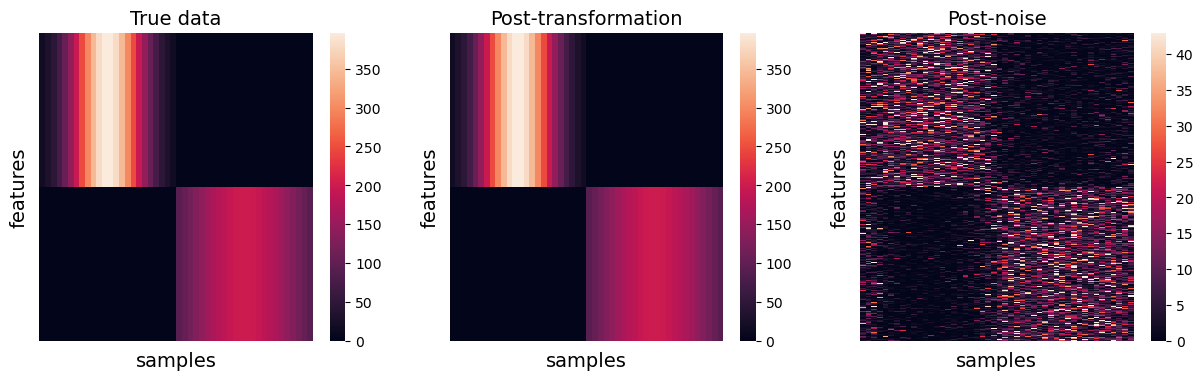

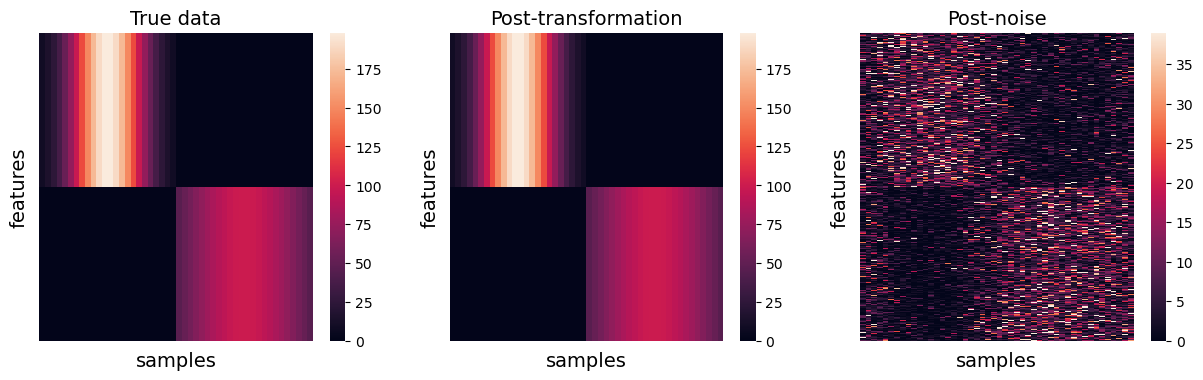

In [4]:
true_mod1, noise_mod1, mf_mod1 = create_sim_data('mod1', n_timepoints=4, n_subjects=12, 
                                                 rank=2, C_=2e3)
true_mod2, noise_mod2, mf_mod2 = create_sim_data('mod2', n_timepoints=4, n_subjects=12, 
                                                 rank=2, C_=1e3)

#softmax (along samples, features sum to 1 per sample) + clr transform (pseudocount of .01) of true data

In [5]:
mod1_array = true_mod1.to_dataframe().T.values

In [6]:
true_mod1_closed = closure(softmax(mod1_array))
true_mod1_closed = biom.Table(true_mod1_closed.T, true_mod1.to_dataframe().index, 
                              true_mod1.to_dataframe().columns)
true_mod1_clr = clr_transformation(true_mod1_closed, pseudocount=0.01)

In [7]:
true_mod1_clr = true_mod1_clr.to_dataframe().values + 2
true_mod1_clr = biom.Table(true_mod1_clr, true_mod1.to_dataframe().index, 
                           true_mod1.to_dataframe().columns)

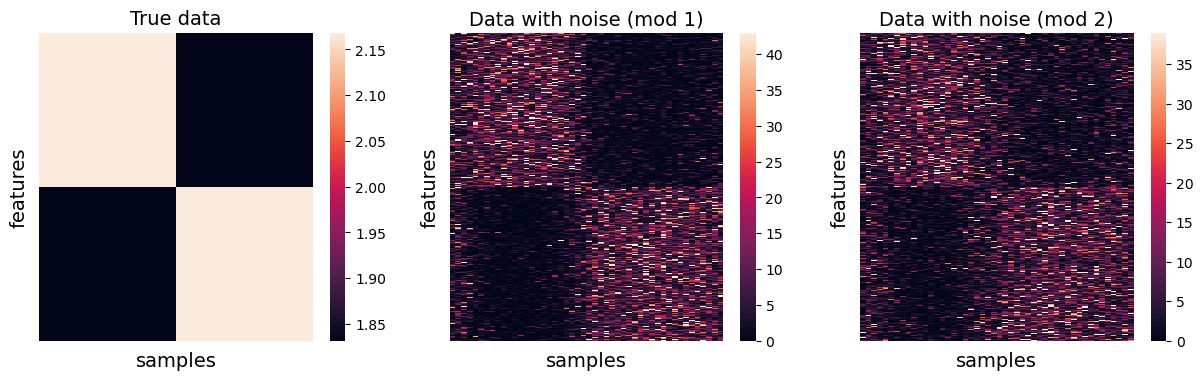

In [8]:
# plot data
fig, axn = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(true_mod1_clr.matrix_data.toarray(), robust=False, 
            ax=axn[0], xticklabels=False, yticklabels=False)
sns.heatmap(noise_mod1.matrix_data.toarray(), robust=True, 
            ax=axn[1], xticklabels=False, yticklabels=False)
sns.heatmap(noise_mod2.matrix_data.toarray(), robust=True, 
            ax=axn[2], xticklabels=False, yticklabels=False)
axn[0].set_ylabel('features', color='black', fontsize=14)
axn[0].set_xlabel('samples', color='black', fontsize=14)
axn[0].set_title('True data', color='black', fontsize=14)
axn[1].set_ylabel('features', color='black', fontsize=14)
axn[1].set_xlabel('samples', color='black', fontsize=14)
axn[1].set_title('Data with noise (mod 1)', color='black', fontsize=14)
axn[2].set_ylabel('features', color='black', fontsize=14)
axn[2].set_xlabel('samples', color='black', fontsize=14)
axn[2].set_title('Data with noise (mod 2)', color='black', fontsize=14)
#plt.savefig('{}{}_sim_data_heatmap.png'.format(fig_path, C_mod2),
#            bbox_inches='tight')
plt.show()

In [9]:
#run joint-ctf
(subject_loads, feature_loads, state_loads,
evals, var_explained, feature_covs) = joint_ctf(tables=[noise_mod1, noise_mod2],
                                                sample_metadatas=[mf_mod1, mf_mod2],
                                                modality_ids=['mod1', 'mod2'],
                                                individual_id_column='ind_id',
                                                state_column='timepoint')
print(evals)
print(var_explained.T)

Calculate components for component_1
Reached convergence in 7 iterations
Calculate components for component_2
Reached convergence in 21 iterations
Calculate components for component_3
Reached convergence in 17 iterations
      component_1  component_2  component_3
mod1  3896.588283  1813.162790  1580.780510
mod2  2912.309488  1259.380113  1258.123933
               component_1  component_2  component_3
var_explained     0.555403     0.236654     0.207943


In [10]:
#run joint-ctf
(true_subject_loads, true_feature_loads, 
true_state_loads, true_evals,
true_var_explained, true_feature_covs) = joint_ctf(tables=[true_mod1_clr],
                                                   sample_metadatas=[mf_mod1],
                                                   modality_ids=['mod0'],
                                                   individual_id_column='ind_id',
                                                   state_column='timepoint')
print(true_evals)
print(true_var_explained.T)

Calculate components for component_1
Reached convergence in 2 iterations
Calculate components for component_2
Reached convergence in 3 iterations
Calculate components for component_3
Reached convergence in 5 iterations
      component_1  component_2  component_3
mod0   130.960616     0.000146     0.000003
               component_1   component_2   component_3
var_explained          1.0  8.696994e-10  3.041184e-17


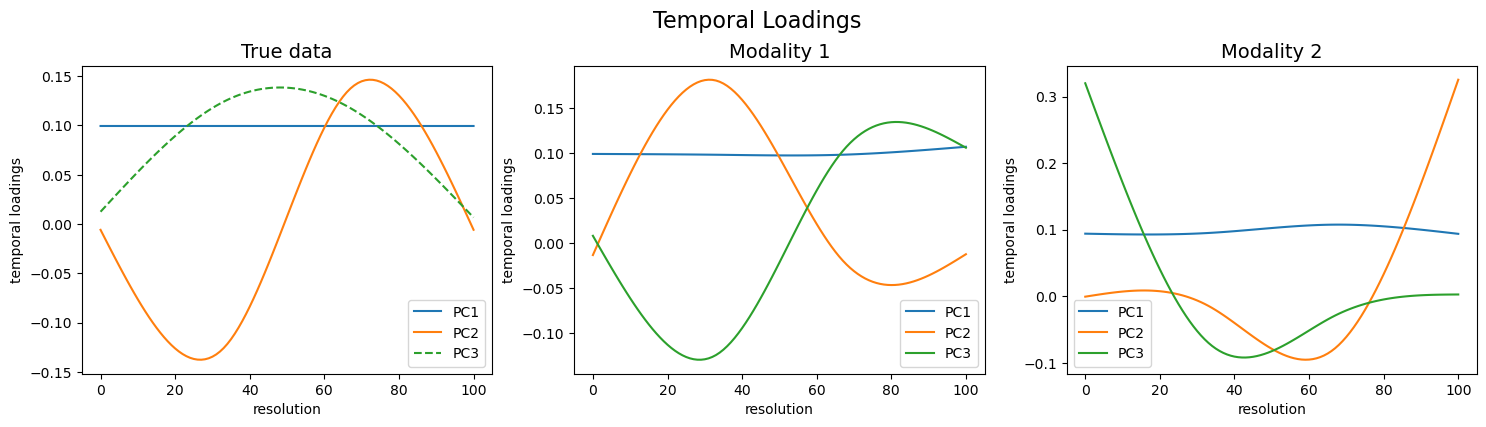

In [11]:
#temporal loadings
fig, axn = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
for component,label,ls in zip(['component_1', 'component_2', 'component_3'],
                            ['PC1', 'PC2', 'PC3'], ['-', '-', '--']):
    axn[0].plot(true_state_loads['mod0'][component], 
                label=label, linestyle=ls)
axn[0].legend()
axn[0].set_title('True data', fontsize=14)
axn[1].plot(state_loads['mod1'][['component_1', 'component_2', 'component_3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[1].legend()
axn[1].set_title('Modality 1', fontsize=14)
axn[2].plot(state_loads['mod2'][['component_1', 'component_2', 'component_3']],
            label=['PC1', 'PC2', 'PC3'])
axn[2].legend()
axn[2].set_title('Modality 2', fontsize=14)
plt.suptitle('Temporal Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel='resolution', ylabel='temporal loadings')
plt.show()

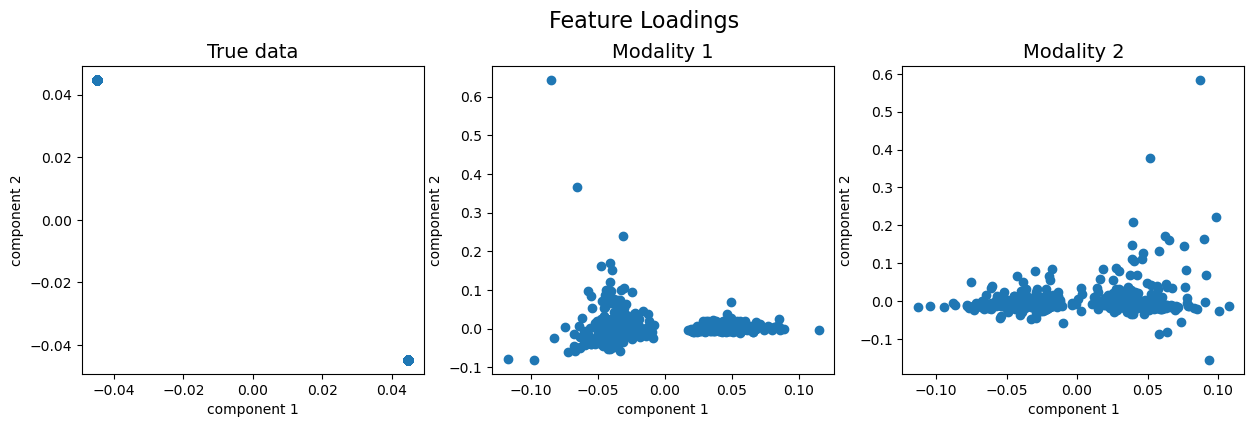

In [12]:
#individual loadings
comp1 = 'component_1'
comp2 = 'component_2'

fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
axn[0].scatter(true_feature_loads['mod0'][comp1],
               true_feature_loads['mod0'][comp2])
axn[0].set_title('True data', fontsize=14)
axn[1].scatter(feature_loads['mod1'][comp1],
               feature_loads['mod1'][comp2])
axn[1].set_title('Modality 1', fontsize=14)
axn[2].scatter(feature_loads['mod2'][comp1],
               feature_loads['mod2'][comp2])
axn[2].set_title('Modality 2', fontsize=14)
plt.suptitle('Feature Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

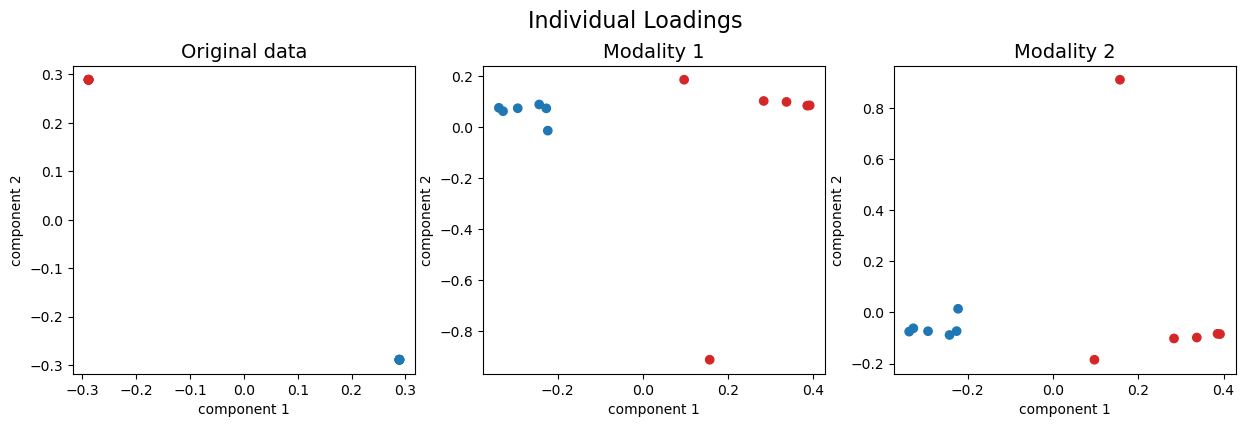

In [13]:
#individual loadings
comp1 = 'component_1'
comp2 = 'component_2'
mf1 = mf_mod1.groupby('ind_id').agg({'group':'first'})
group_colors = {'group1': 'tab:red', 
                'group2': 'tab:blue',
                'group3': 'tab:green'}

fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
axn[0].scatter(true_subject_loads['mod0'][comp1],
               true_subject_loads['mod0'][comp2],
               c=mf1['group'].map(group_colors))
axn[0].set_title('Original data', fontsize=14)
axn[1].scatter(subject_loads['mod1'][comp1],
               subject_loads['mod1'][comp2],
               c=mf1['group'].map(group_colors))
axn[1].set_title('Modality 1', fontsize=14)
axn[2].scatter(subject_loads['mod2'][comp1],
               subject_loads['mod2'][comp2],
               c=mf1['group'].map(group_colors))
axn[2].set_title('Modality 2', fontsize=14)
plt.suptitle('Individual Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

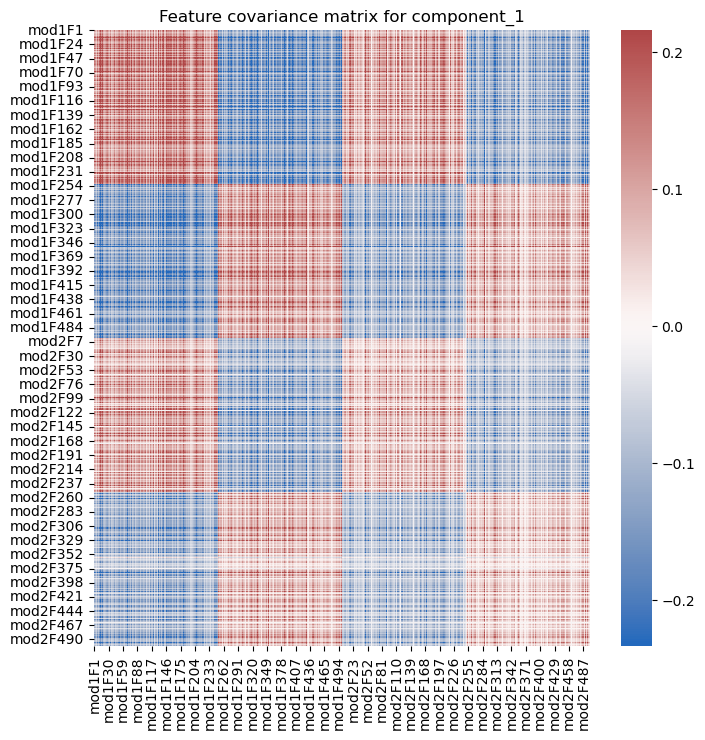

In [14]:
#get feature cov matrix and reorder IDs
feature_order1 = noise_mod1.ids(axis='observation').tolist()
feature_order2 = noise_mod2.ids(axis='observation').tolist()
feature_order = feature_order1 + feature_order2

component = 'component_1'
cov_table = feature_covs[component]
cov_table = cov_table.loc[feature_order, feature_order]

#plot heatmap of feature covariance matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cov_table, robust=True, cmap='vlag', center=0)
plt.title('Feature covariance matrix for {}'.format(component))
plt.show()

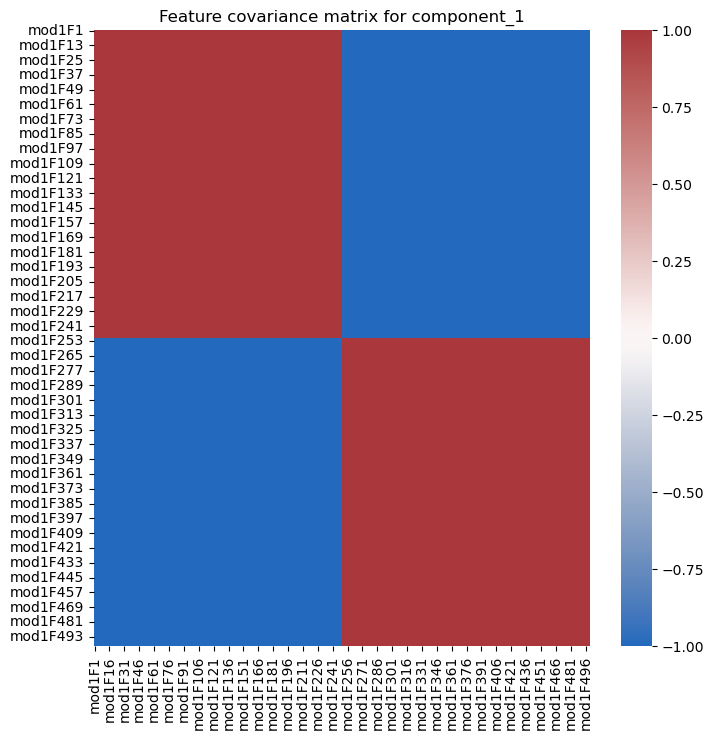

In [15]:
true_order = true_mod1.ids(axis='observation').tolist()
true_cov_table = true_feature_covs[component]
true_cov_table = true_cov_table.loc[true_order, true_order]

plt.figure(figsize=(8, 8))
sns.heatmap(true_cov_table, robust=True, cmap='vlag', center=0)
plt.title('Feature covariance matrix for {}'.format(component))
plt.show()

### Comparison with TEMPTED

In [16]:
tempted_res = tempted_factorize(true_mod1_clr, mf_mod1,
                                'ind_id', 'timepoint')

Prop explained: [1.         0.99969818 0.78207096]
Prop explained argsort: [0 1 2]
Eigenvalues pre-sorting: [1.30960616e+02 1.45782684e-04 2.35611155e-06]
Eigenvalues post-sorting: [1.30960616e+02 1.45782684e-04 2.35611155e-06]


In [17]:
tempted_res_noisy1 = tempted_factorize(noise_mod1, mf_mod1,
                                      'ind_id', 'timepoint')
tempted_res_noisy2 = tempted_factorize(noise_mod2, mf_mod2,
                                      'ind_id', 'timepoint')

Prop explained: [0.16838227 0.06695671 0.05499015]
Prop explained argsort: [0 1 2]
Eigenvalues pre-sorting: [3901.40237108 2516.97191657 1271.97552009]
Eigenvalues post-sorting: [3901.40237108 2516.97191657 1271.97552009]
Prop explained: [0.10458837 0.06349108 0.06436877]
Prop explained argsort: [0 2 1]
Eigenvalues pre-sorting: [2915.835594   1263.83037436 1262.54556099]
Eigenvalues post-sorting: [2915.835594   1262.54556099 1263.83037436]


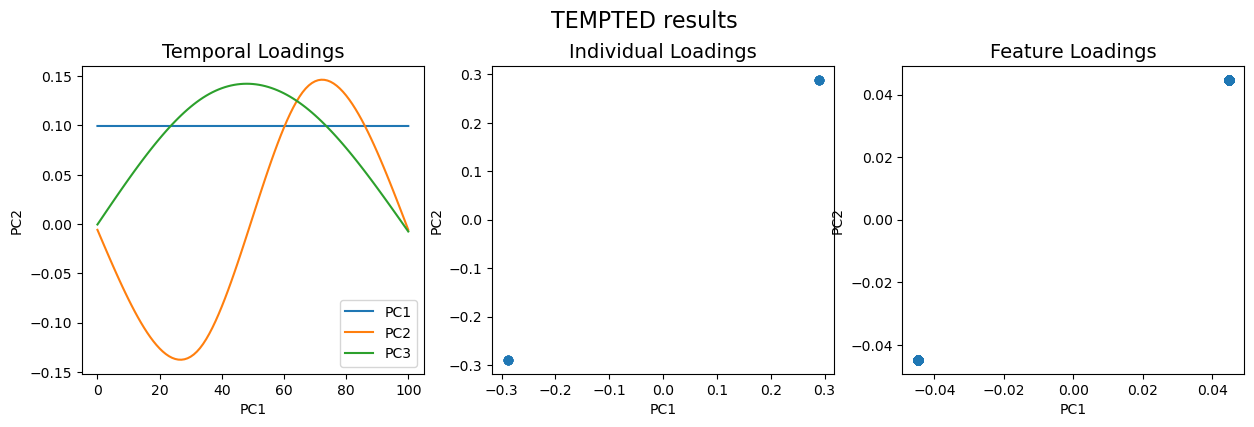

In [18]:
#feature loadings
comp1 = 'PC1'
comp2 = 'PC2'

fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
axn[0].plot(tempted_res[1][['PC1', 'PC2', 'PC3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()
axn[1].scatter(tempted_res[0].samples[comp1],
               tempted_res[0].samples[comp2])
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(tempted_res[0].features[comp1],
               tempted_res[0].features[comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('TEMPTED results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

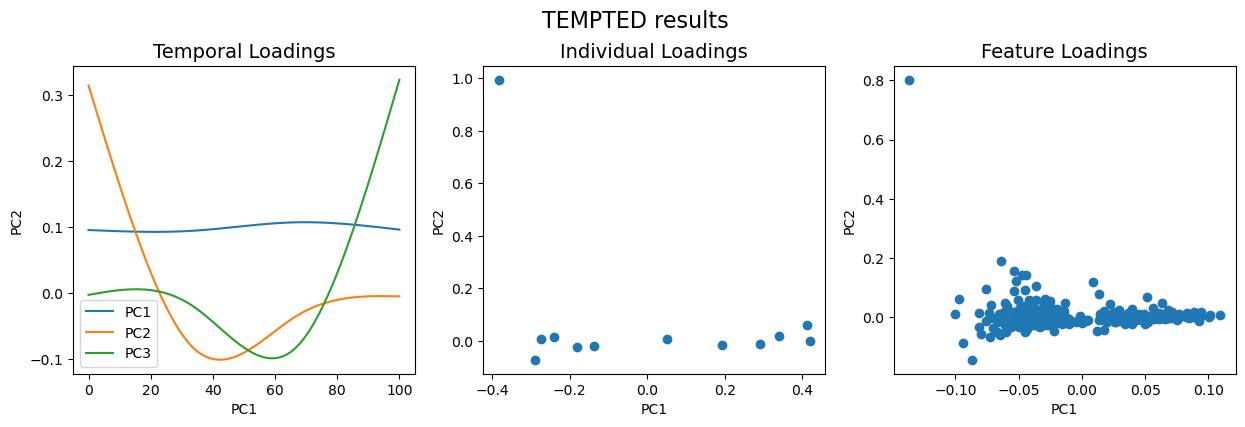

In [19]:
#feature loadings
comp1 = 'PC1'
comp2 = 'PC2'

fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
axn[0].plot(tempted_res_noisy2[1][['PC1', 'PC2', 'PC3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()
axn[1].scatter(tempted_res_noisy2[0].samples[comp1],
               tempted_res_noisy2[0].samples[comp2])
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(tempted_res_noisy2[0].features[comp1],
               tempted_res_noisy2[0].features[comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('TEMPTED results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

In [20]:
#run joint-ctf
(subject_loads, feature_loads, state_loads,
evals, var_explained, feature_covs) = joint_ctf(tables=[noise_mod2],
                                                sample_metadatas=[mf_mod2],
                                                modality_ids=['mod2'],
                                                individual_id_column='ind_id',
                                                state_column='timepoint')
print(evals)
print(var_explained.T)

Calculate components for component_1
Reached convergence in 8 iterations
Calculate components for component_2
Reached convergence in 7 iterations
Calculate components for component_3
Reached convergence in 6 iterations
      component_1  component_2  component_3
mod2  2916.650892  1263.229444  1261.486655
               component_1  component_2  component_3
var_explained     0.572703     0.221953     0.205344


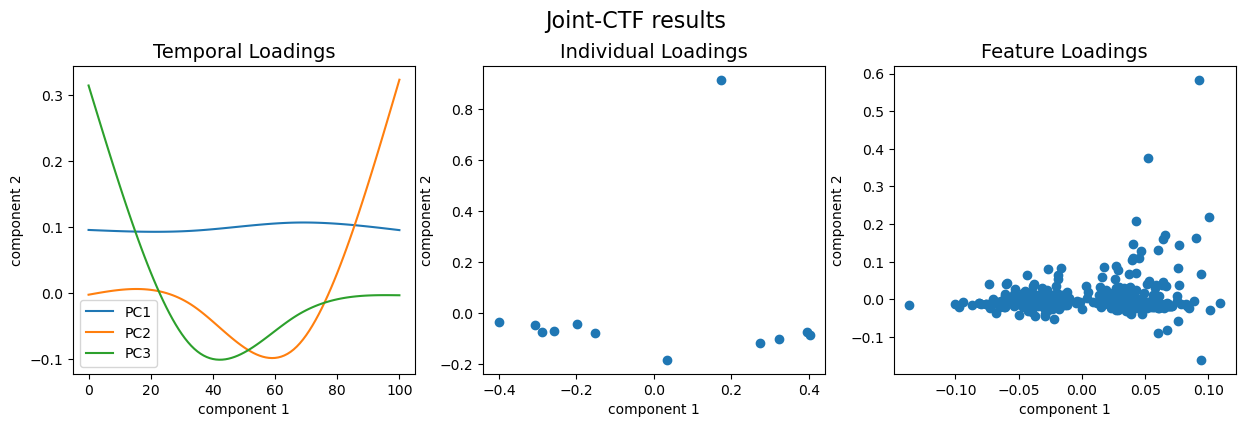

In [21]:
#feature loadings
comp1 = 'component_1'
comp2 = 'component_2'

fig, axn = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
axn[0].plot(state_loads['mod2'][['component_1', 'component_2', 'component_3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()
axn[1].scatter(subject_loads['mod2'][comp1],
               subject_loads['mod2'][comp2])
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(feature_loads['mod2'][comp1],
               feature_loads['mod2'][comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('Joint-CTF results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

### Test 1

One modality with sine and constant noise patterns

In [22]:
def sine_func(x):
    return 50*(1+np.sin(x))

def add_one(x):
    return x+1

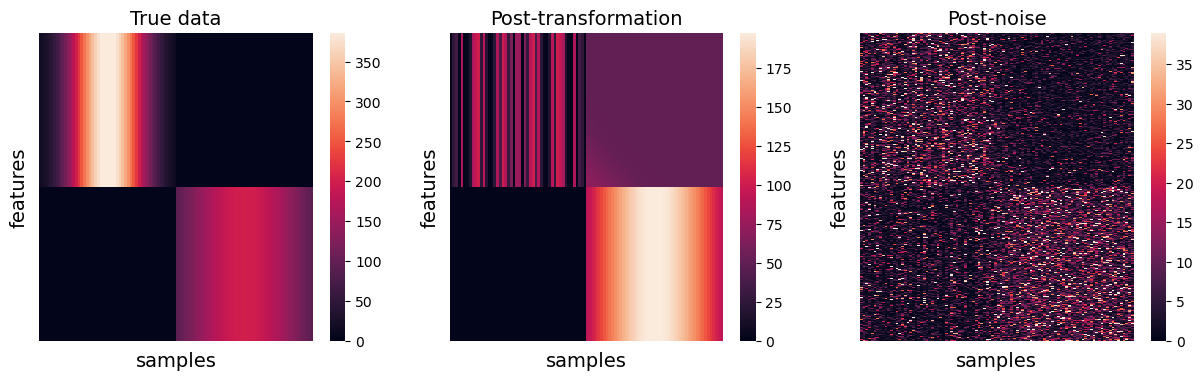

In [23]:
true_mod1, noisy_mod1, mf_mod1 = create_sim_data('mod1', n_timepoints=10, n_subjects=10, 
                                                 num_samples=100, num_features=500,
                                                 rank=2, C_=2e3, spar=2e3,
                                                 shape_function=[sine_func, None],
                                                 fts_lst=[(0,250),(250,500)], 
                                                 sps_lst=[(0,100),(0,100)])

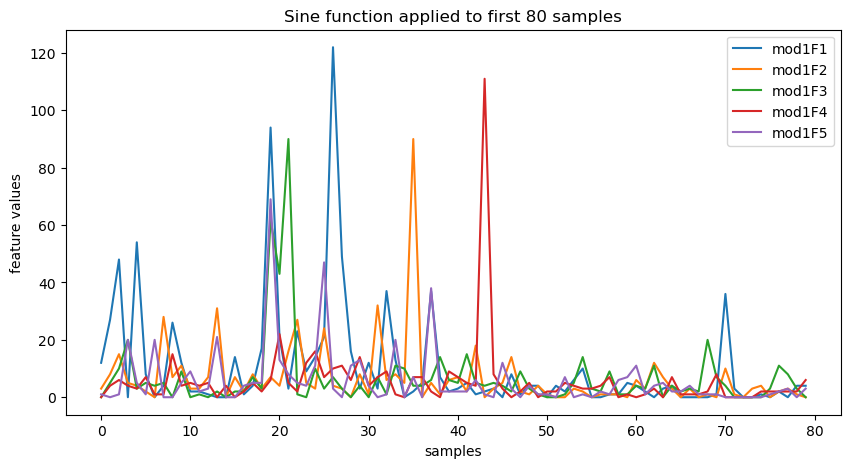

In [24]:
n_samples=80
#plot sine function applied to first 3 samples
plt.figure(figsize=(10, 5))
plt.plot(noisy_mod1.to_dataframe().values[0:5, 0:n_samples].T, 
         label=noisy_mod1.to_dataframe().index[0:5])
plt.xlabel('samples')
plt.ylabel('feature values')
plt.title('Sine function applied to first {} samples'.format(n_samples))
plt.legend()
plt.show()

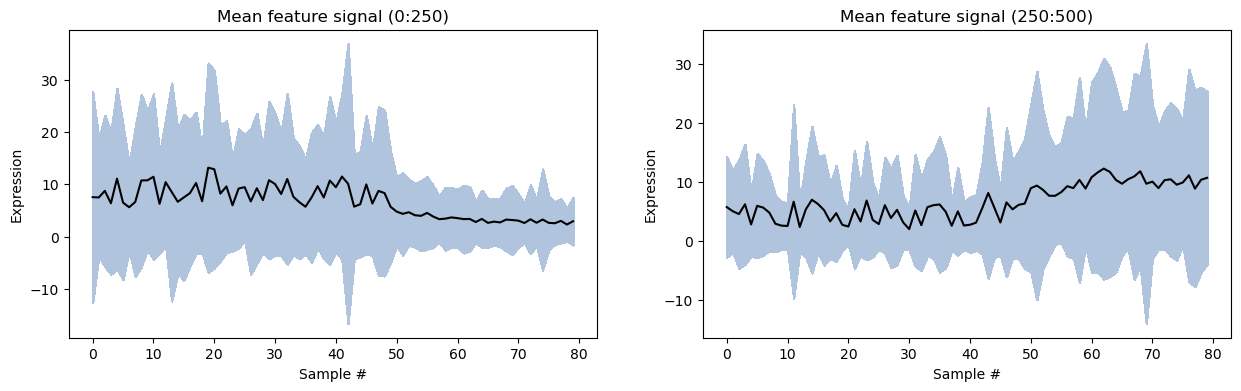

In [25]:
samples_min = 0
samples_max = 80
feat_min = 0
feat_max = 250
x = range(samples_min, samples_max, 1)
features1 = noisy_mod1.to_dataframe().values[0:250, samples_min:samples_max].T
features2 = noisy_mod1.to_dataframe().values[250:500, samples_min:samples_max].T

# Calculate mean signal and standard deviation
mean_signal1 = np.mean(features1, axis=1)
std_deviation1 = np.std(features1, axis=1)
mean_signal2 = np.mean(features2, axis=1)
std_deviation2 = np.std(features2, axis=1)

# Plotting
fig, axn = plt.subplots(1, 2, figsize=(15, 4), sharey=False)
axn[0].plot(x, mean_signal1, label='Mean Signal', color='black')
axn[1].plot(x, mean_signal2, label='Mean Signal', color='black')

# Plot shaded areas for individual features
for i in range(250):
    axn[0].fill_between(x, mean_signal1 - std_deviation1, 
                        mean_signal1 + std_deviation1, 
                        alpha=0.2, label='Feature {}'.format(i+1),
                        color='lightsteelblue')

for i in range(250, 500):
    axn[1].fill_between(x, mean_signal2 - std_deviation2, 
                        mean_signal2 + std_deviation2, 
                        alpha=0.2, label='Feature {}'.format(i+1),
                        color='lightsteelblue')

axn[0].set_xlabel('Sample #')
axn[0].set_ylabel('Expression')
axn[0].set_title('Mean feature signal (0:250)')
axn[1].set_xlabel('Sample #')
axn[1].set_ylabel('Expression')
axn[1].set_title('Mean feature signal (250:500)')
plt.show()

In [26]:
#run joint-ctf
(mod1_subject_loads, mod1_feature_loads, 
mod1_state_loads, mod1_subject_lambdas,
mod1_var_explained, mod1_feature_covs) = joint_ctf(tables=[noisy_mod1],
                                                   sample_metadatas=[mf_mod1],
                                                   modality_ids=['mod1'],
                                                   individual_id_column='ind_id',
                                                   state_column='timepoint')
print(mod1_subject_lambdas)
print(mod1_var_explained.T)

Calculate components for component_1
Reached convergence in 6 iterations
Calculate components for component_2
Reached convergence in 8 iterations
Calculate components for component_3
Reached convergence in 10 iterations
      component_1  component_2  component_3
mod1  1986.449537  1359.039815   724.807408
               component_1  component_2  component_3
var_explained     0.532003     0.311205     0.156792


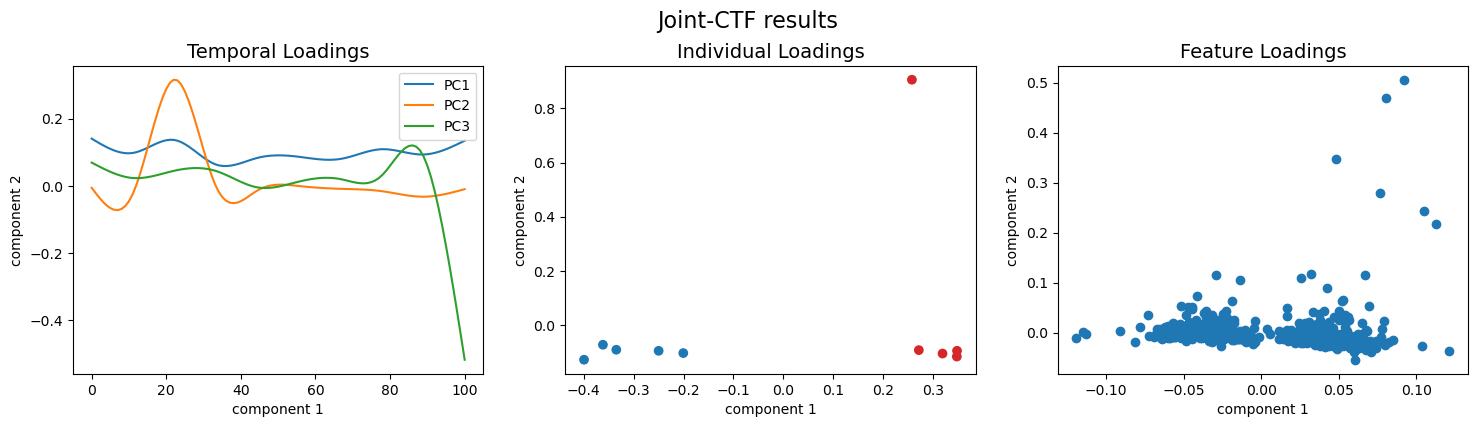

In [27]:
#visualize loadings
comp1 = 'component_1'
comp2 = 'component_2'
mf1 = mf_mod1.groupby('ind_id').agg({'group':'first'})
group_colors = {'group1': 'tab:red', 
                'group2': 'tab:blue',
                'group3': 'tab:green'}

fig, axn = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
axn[0].plot(mod1_state_loads['mod1'][['component_1', 'component_2', 'component_3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()
axn[1].scatter(mod1_subject_loads['mod1'][comp1],
               mod1_subject_loads['mod1'][comp2],
               c=mf1['group'].map(group_colors))
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(mod1_feature_loads['mod1'][comp1],
               mod1_feature_loads['mod1'][comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('Joint-CTF results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

### Test 2

One modality with sine, sigmoid, and constant noise patterns

In [28]:
def sigmoid(x):
    #fit data between -10 and 10
    x = (x/30) - 10
    x = 1/(1+np.exp(-x))
    return 200*x

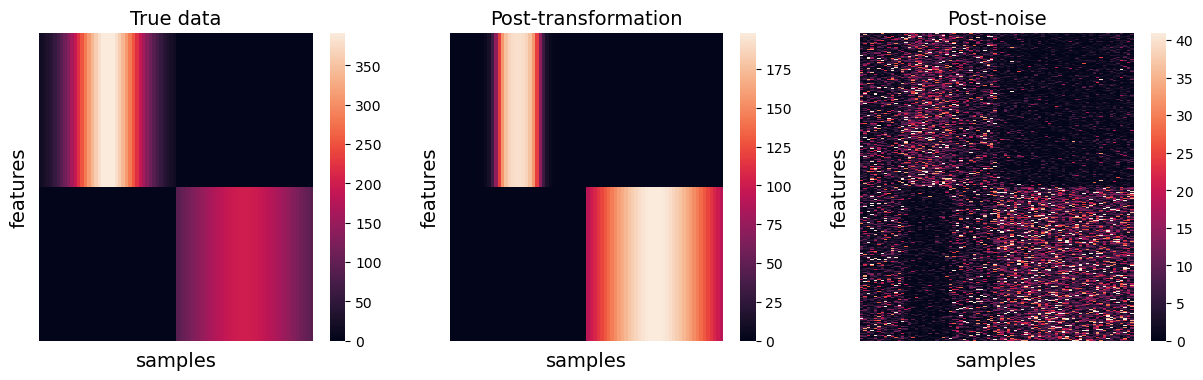

In [29]:
true_mod2, noisy_mod2, mf_mod2 = create_sim_data('sigm', n_timepoints=8, n_subjects=10, 
                                                 num_samples=80, num_features=500,
                                                 rank=2, C_=2e3, spar=2e3,
                                                 shape_function=[sigmoid, None],
                                                 fts_lst=[(0,250),(250,500)], 
                                                 sps_lst=[(0,80),(0,80)])

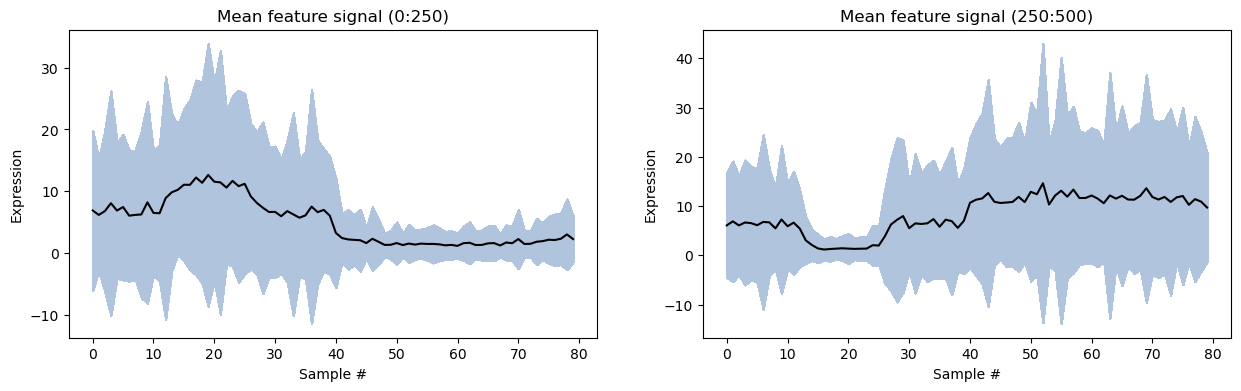

In [30]:
samples_min = 0
samples_max = 80
feat_min = 0
feat_max = 250
x = range(samples_min, samples_max, 1)
features1 = noisy_mod2.to_dataframe().values[0:250, samples_min:samples_max].T
features2 = noisy_mod2.to_dataframe().values[250:500, samples_min:samples_max].T

# Calculate mean signal and standard deviation
mean_signal1 = np.mean(features1, axis=1)
std_deviation1 = np.std(features1, axis=1)
mean_signal2 = np.mean(features2, axis=1)
std_deviation2 = np.std(features2, axis=1)

# Plotting
fig, axn = plt.subplots(1, 2, figsize=(15, 4), sharey=False)
axn[0].plot(x, mean_signal1, label='Mean Signal', color='black')
axn[1].plot(x, mean_signal2, label='Mean Signal', color='black')

# Plot shaded areas for individual features
for i in range(250):
    axn[0].fill_between(x, mean_signal1 - std_deviation1, 
                        mean_signal1 + std_deviation1, 
                        alpha=0.2, label='Feature {}'.format(i+1),
                        color='lightsteelblue')

for i in range(250, 500):
    axn[1].fill_between(x, mean_signal2 - std_deviation2, 
                        mean_signal2 + std_deviation2, 
                        alpha=0.2, label='Feature {}'.format(i+1),
                        color='lightsteelblue')

axn[0].set_xlabel('Sample #')
axn[0].set_ylabel('Expression')
axn[0].set_title('Mean feature signal (0:250)')
axn[1].set_xlabel('Sample #')
axn[1].set_ylabel('Expression')
axn[1].set_title('Mean feature signal (250:500)')
plt.show()

In [31]:
#run joint-ctf
(mod2_subject_loads, mod2_feature_loads, 
mod2_state_loads, mod2_subject_lambdas,
mod2_var_explained, mod2_feature_covs) = joint_ctf(tables=[noisy_mod2],
                                                   sample_metadatas=[mf_mod2],
                                                   modality_ids=['sigm'],
                                                   individual_id_column='ind_id',
                                                   state_column='timepoint')
print(mod2_subject_lambdas)
print(mod2_var_explained.T)

Calculate components for component_1
Reached convergence in 5 iterations
Calculate components for component_2
Reached convergence in 12 iterations
Calculate components for component_3
Reached convergence in 9 iterations
      component_1  component_2  component_3
sigm  2603.471041  1496.835955   972.009363
               component_1  component_2  component_3
var_explained     0.619871     0.348327     0.031802


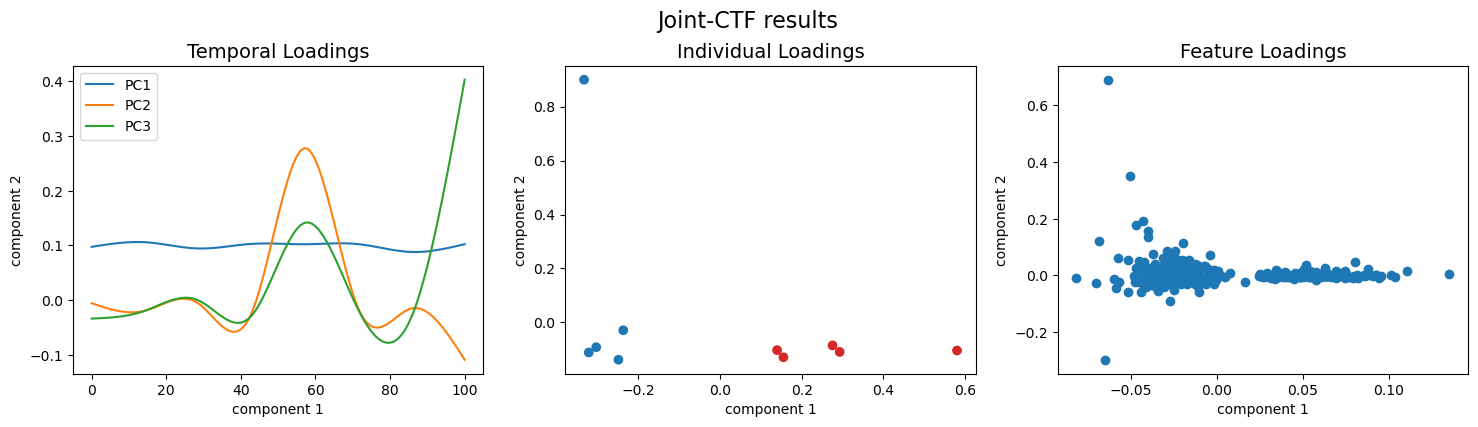

In [32]:
#visualize loadings
comp1 = 'component_1'
comp2 = 'component_2'
mf2 = mf_mod2.groupby('ind_id').agg({'group':'first'})
group_colors = {'group1': 'tab:red', 
                'group2': 'tab:blue',
                'group3': 'tab:green'}

fig, axn = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
axn[0].plot(mod2_state_loads['sigm'][['component_1', 'component_2', 'component_3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[0].set_title('Temporal Loadings', fontsize=14)
axn[0].legend()
axn[1].scatter(mod2_subject_loads['sigm'][comp1],
               mod2_subject_loads['sigm'][comp2],
               c=mf2['group'].map(group_colors))
axn[1].set_title('Individual Loadings', fontsize=14)
axn[2].scatter(mod2_feature_loads['sigm'][comp1],
               mod2_feature_loads['sigm'][comp2])
axn[2].set_title('Feature Loadings', fontsize=14)
plt.suptitle('Joint-CTF results', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

In [33]:
# true_mod2, noisy_mod2, mf_mod2 = create_sim_data('mod1', n_timepoints=4, n_subjects=12, 
#                                                  rank=2, C_=2e3)

# #get half patients and half features
# true_mod1_df_sub1 = true_mod2.to_dataframe().iloc[0:250,0:12]
# true_mod1_df_sub2 = true_mod2.to_dataframe().iloc[0:250,12:24]
# true_mod1_df_sub3 = true_mod2.to_dataframe().iloc[0:250,24:48]
# true_mod1_df_sub4 = true_mod2.to_dataframe().iloc[250:500,0:24]
# noisy_mod1_df_sub = true_mod2.to_dataframe().iloc[250:500,24:48]

# #apply sine function to all rows
# true_mod1_df_sub1 = 100*(1 + true_mod1_df_sub1.apply(np.sin, axis=1))
# noisy_mod1_df_sub = 100*(1 + noisy_mod1_df_sub.apply(np.sin, axis=1))
# #apply sigmoid function to all rows
# #true_mod1_df_sub2 = 100*true_mod1_df_sub2.apply(lambda x: (1/(1+np.exp(-x))), axis=1)
# x = np.linspace(-10, 10, 12)
# x = [1/(1+np.exp(-i)) for i in x]
# #make all rows from true_mod1_df_sub2 equal to x
# true_mod1_df_sub2 = 100*pd.DataFrame([x]*250, columns=true_mod1_df_sub2.columns,
#                                      index=true_mod1_df_sub2.index)

# #first half
# mod1_df1 = pd.concat([true_mod1_df_sub1, true_mod1_df_sub2], axis=1)
# mod1_df1 = pd.concat([mod1_df1, true_mod1_df_sub3], axis=1)
# #second half
# mod1_df2 = pd.concat([true_mod1_df_sub4, noisy_mod1_df_sub], axis=1)
# #final concat
# mod2_df = pd.concat([mod1_df1, mod1_df2])
# mod2_df = biom.Table(mod2_df.values, mod2_df.index, mod2_df.columns)

# # plot data
# plt.figure(figsize=(5, 5))
# sns.heatmap(mod2_df.to_dataframe())
# plt.xlabel('samples')
# plt.ylabel('features')
# plt.show()

### Test 3

Two modalities:
- Mod1: sine + constant noise
- Mod2: Sigma + constant noise

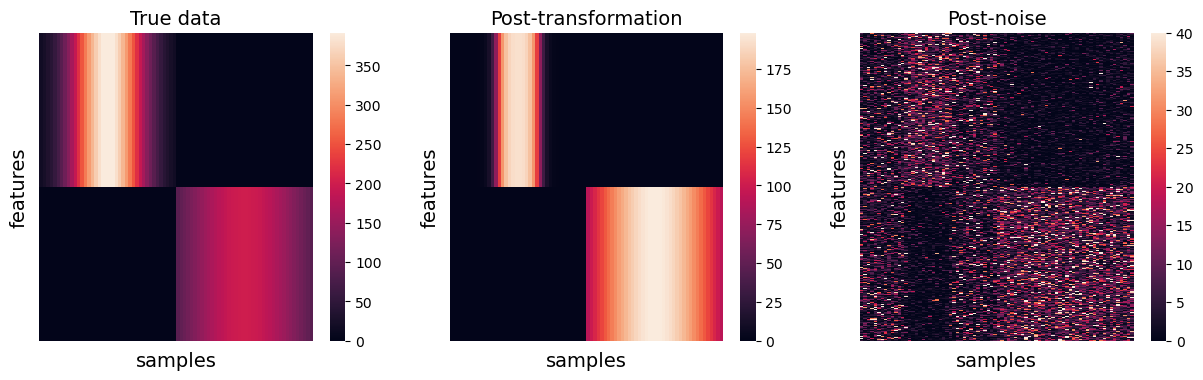

In [34]:
true_mod3, noisy_mod3, mf_mod3 = create_sim_data('mod1', n_timepoints=8, n_subjects=10, 
                                                 num_samples=80, num_features=500,
                                                 rank=2, C_=2e3, spar=2e3,
                                                 shape_function=[sigmoid, None],
                                                 fts_lst=[(0,250),(250,500)], 
                                                 sps_lst=[(0,80),(0,80)])

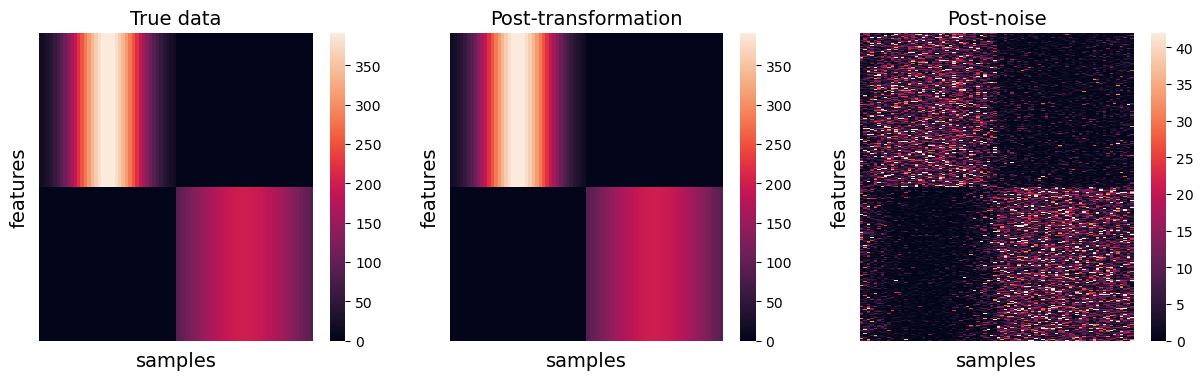

In [35]:
true_mod4, noisy_mod4, mf_mod4 = create_sim_data('mod2', n_timepoints=8, n_subjects=10, 
                                                 num_samples=80, num_features=500,
                                                 rank=2, C_=2e3, spar=2e3)

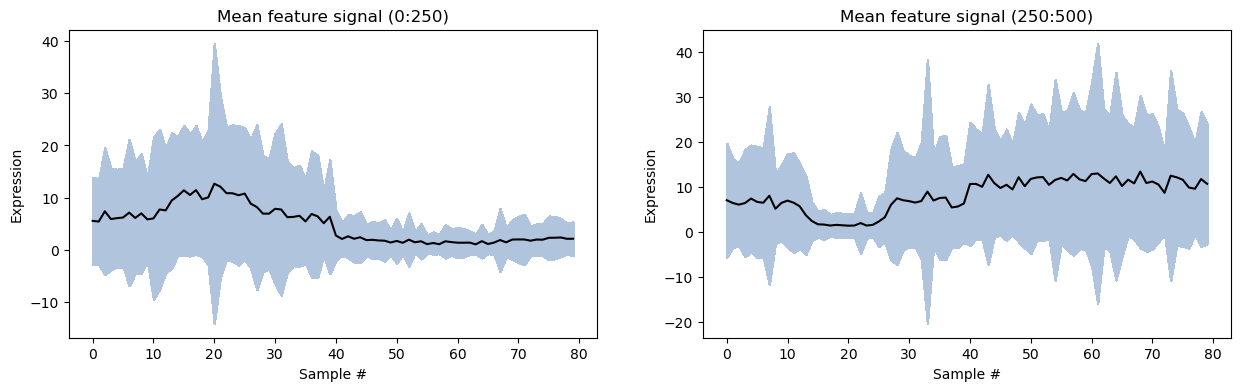

In [36]:
samples_min = 0
samples_max = 80
feat_min = 0
feat_max = 250
x = range(samples_min, samples_max, 1)
features1 = noisy_mod3.to_dataframe().values[0:250, samples_min:samples_max].T
features2 = noisy_mod3.to_dataframe().values[250:500, samples_min:samples_max].T

# Calculate mean signal and standard deviation
mean_signal1 = np.mean(features1, axis=1)
std_deviation1 = np.std(features1, axis=1)
mean_signal2 = np.mean(features2, axis=1)
std_deviation2 = np.std(features2, axis=1)

# Plotting
fig, axn = plt.subplots(1, 2, figsize=(15, 4), sharey=False)
axn[0].plot(x, mean_signal1, label='Mean Signal', color='black')
axn[1].plot(x, mean_signal2, label='Mean Signal', color='black')

# Plot shaded areas for individual features
for i in range(250):
    axn[0].fill_between(x, mean_signal1 - std_deviation1, 
                        mean_signal1 + std_deviation1, 
                        alpha=0.2, label='Feature {}'.format(i+1),
                        color='lightsteelblue')

for i in range(250, 500):
    axn[1].fill_between(x, mean_signal2 - std_deviation2, 
                        mean_signal2 + std_deviation2, 
                        alpha=0.2, label='Feature {}'.format(i+1),
                        color='lightsteelblue')

axn[0].set_xlabel('Sample #')
axn[0].set_ylabel('Expression')
axn[0].set_title('Mean feature signal (0:250)')
axn[1].set_xlabel('Sample #')
axn[1].set_ylabel('Expression')
axn[1].set_title('Mean feature signal (250:500)')
plt.show()

In [37]:
#run joint-ctf
(subject_loads, feature_loads, state_loads,
evals, var_explained, feature_covs) = joint_ctf(tables=[noisy_mod3, noisy_mod4],
                                                sample_metadatas=[mf_mod3, mf_mod4],
                                                modality_ids=['mod1', 'mod2'],
                                                individual_id_column='ind_id',
                                                state_column='timepoint')
print(evals)
print(var_explained.T)

Calculate components for component_1
Reached convergence in 5 iterations
Calculate components for component_2
Reached convergence in 14 iterations
Calculate components for component_3
Reached convergence in 21 iterations
      component_1  component_2  component_3
mod1  2472.486670  1750.548080  1555.152467
mod2  3487.325343  1697.986194  1179.576638
               component_1  component_2  component_3
var_explained     0.524415     0.251566     0.224019


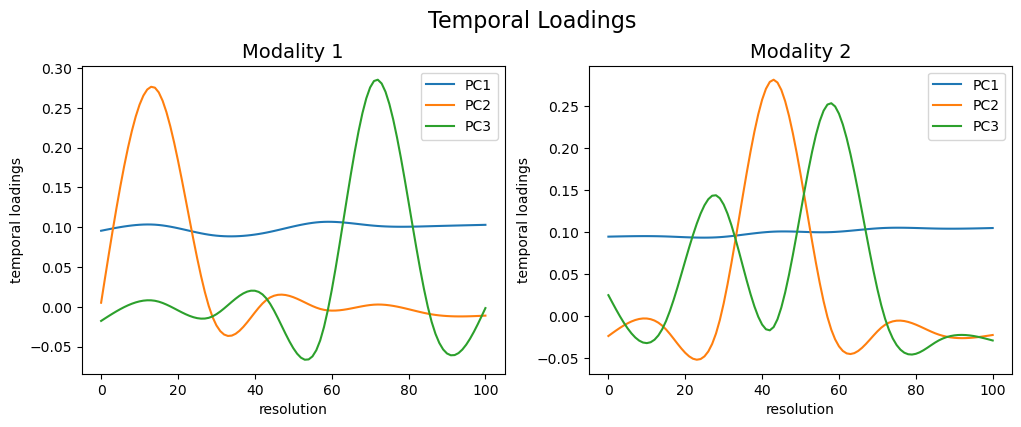

In [38]:
#temporal loadings
fig, axn = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
axn[0].plot(state_loads['mod1'][['component_1', 'component_2', 'component_3']], 
            label=['PC1', 'PC2', 'PC3'])
axn[0].legend()
axn[0].set_title('Modality 1', fontsize=14)
axn[1].plot(state_loads['mod2'][['component_1', 'component_2', 'component_3']],
            label=['PC1', 'PC2', 'PC3'])
axn[1].legend()
axn[1].set_title('Modality 2', fontsize=14)
plt.suptitle('Temporal Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel='resolution', ylabel='temporal loadings')
plt.show()

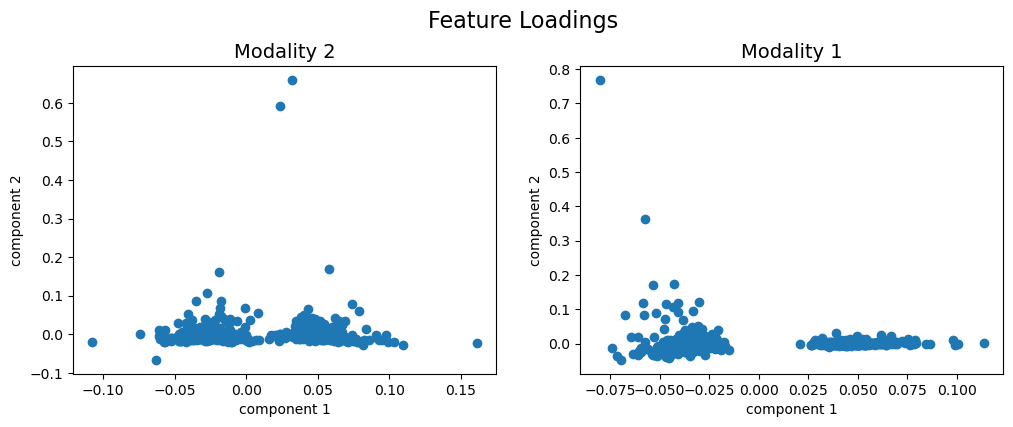

In [39]:
#feature loadings
comp1 = 'component_1'
comp2 = 'component_2'

fig, axn = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
axn[0].scatter(feature_loads['mod1'][comp1],
               feature_loads['mod1'][comp2])
axn[0].set_title('Modality 2', fontsize=14)
axn[1].scatter(feature_loads['mod2'][comp1],
               feature_loads['mod2'][comp2])
axn[1].set_title('Modality 1', fontsize=14)
plt.suptitle('Feature Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()

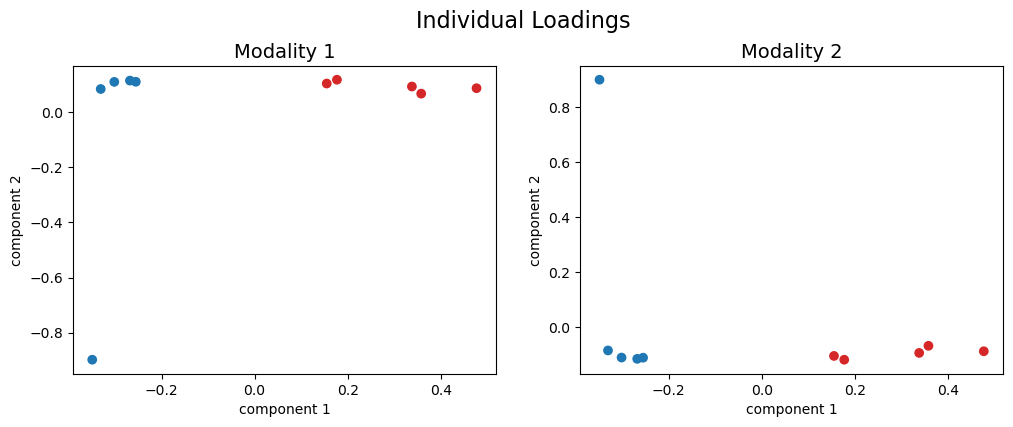

In [40]:
#individual loadings
comp1 = 'component_1'
comp2 = 'component_2'
mf3 = mf_mod3.groupby('ind_id').agg({'group':'first'})
group_colors = {'group1': 'tab:red', 
                'group2': 'tab:blue',
                'group3': 'tab:green'}

fig, axn = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
axn[0].scatter(subject_loads['mod1'][comp1],
               subject_loads['mod1'][comp2],
               c=mf3['group'].map(group_colors))
axn[0].set_title('Modality 1', fontsize=14)
axn[1].scatter(subject_loads['mod2'][comp1],
               subject_loads['mod2'][comp2],
               c=mf3['group'].map(group_colors))
axn[1].set_title('Modality 2', fontsize=14)
plt.suptitle('Individual Loadings', fontsize=16, y=1.02)
plt.setp(axn, xlabel=comp1.replace('_', ' '), 
         ylabel=comp2.replace('_', ' '))
plt.show()